### Setup

In [1]:
import os
from pymongo import MongoClient
import urllib
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dotenv import load_dotenv

In [2]:
# set this option to wrap wide columns
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_colwidth', None)

### Load data

In [3]:
load_dotenv()

try:
    username = urllib.parse.quote_plus(os.getenv('MONGO_USERNAME'))
    password = urllib.parse.quote_plus(os.getenv('MONGO_PASSWORD'))
    host = os.getenv('MONGO_HOST')
except TypeError:
    print('Please set environment variables first!')
    raise TypeError

myClient = MongoClient(f'mongodb+srv://{username}:{password}@{host}/?retryWrites=true&w=majority')

In [4]:
def read_mongo(db, collection, query={}, no_id=True):
    mydb = myClient[db]
    col = mydb[collection]

    cursor = col.find()
    raw_df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del raw_df['_id']

    return raw_df

In [ ]:
raw_df = read_mongo('myDB', 'data')

In [ ]:
raw_df.head(3)

,ticket_id,type,organization,comment,photo,photo_after,coords,address,subdistrict,district,province,timestamp,state,star,count_reopen,last_activity
0,2022-NHRQWA,[จราจร],[เขตห้วยขวาง],รถติดนานแล้ว,https://storage.googleapis.com/traffy_public_bucket/attachment/2022-07/fed40a2f1defef293b0109a88ee31a55cd325e13.jpg,https://storage.googleapis.com/traffy_public_bucket/attachment/2022-08/7c8ecfb6290d1db4bb2d68c5c79738e44bdf405b.jpg,"[100.56405, 13.75106]",46 ถ. อโศก - ดินแดง แขวง บางกะปิ เขตห้วยขวาง กรุงเทพมหานคร 10310 ประเทศไทย,บางกะปิ,ห้วยขวาง,กรุงเทพมหานคร,2022-07-01 00:01:11.529841+00,เสร็จสิ้น,5.0,NaN,2022-08-01 14:19:25.174322+00
1,2022-D8TD2Q,[ถนน],[เขตคลองสามวา],ถนนพัง,https://storage.googleapis.com/traffy_public_bucket/attachment/2022-07/dd8532c024893a3a3ee5f127e1bd498711f94606.jpg,https://storage.googleapis.com/traffy_public_bucket/attachment/2022-12/c26589705d0e8b60237a6c665c3de46505a5bde6.jpg,"[100.69372, 13.89715]",26/2 ถนน กาญจนาฎเษก แขวง สามวาตะวันตก เขตคลองสามวา กรุงเทพมหานคร 10510 ประเทศไทย,สามวาตะวันตก,คลองสามวา,กรุงเทพมหานคร,2022-07-01 00:01:56.896927+00,เสร็จสิ้น,NaN,NaN,2022-12-13 07:38:21.633096+00
2,2022-E9GUYK,[ถนน],"[เขตคลองเตย, สำนักการโยธา กทม.]",ถนนชำรุด,https://storage.googleapis.com/traffy_public_bucket/attachment/2022-07/07d9586ea2945e82f8af12d98d3c7055b3a678f4.jpg,https://storage.googleapis.com/traffy_public_bucket/attachment/2023-02/1675953454173.jpeg,"[100.55411, 13.71305]",29 ถนน เชื้อเพลิง แขวง คลองเตย เขตคลองเตย กรุงเทพมหานคร 10110 ประเทศไทย,คลองเตย,คลองเตย,กรุงเทพมหานคร,2022-07-01 00:03:18.721622+00,เสร็จสิ้น,NaN,NaN,2023-02-09 14:37:35.67893+00


### Data Exploration

In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70838 entries, 0 to 70837
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ticket_id      70838 non-null  object 
 1   type           70838 non-null  object 
 2   organization   70838 non-null  object 
 3   comment        70838 non-null  object 
 4   photo          70818 non-null  object 
 5   photo_after    63713 non-null  object 
 6   coords         70838 non-null  object 
 7   address        70838 non-null  object 
 8   subdistrict    70838 non-null  object 
 9   district       70838 non-null  object 
 10  province       70838 non-null  object 
 11  timestamp      70838 non-null  object 
 12  state          70838 non-null  object 
 13  star           37962 non-null  float64
 14  count_reopen   40485 non-null  float64
 15  last_activity  70838 non-null  object 
dtypes: float64(2), object(14)
memory usage: 8.6+ MB


In [ ]:
raw_df[['address', 'district', 'province']].head(3)

,address,district,province
0,46 ถ. อโศก - ดินแดง แขวง บางกะปิ เขตห้วยขวาง กรุงเทพมหานคร 10310 ประเทศไทย,ห้วยขวาง,กรุงเทพมหานคร
1,26/2 ถนน กาญจนาฎเษก แขวง สามวาตะวันตก เขตคลองสามวา กรุงเทพมหานคร 10510 ประเทศไทย,คลองสามวา,กรุงเทพมหานคร
2,29 ถนน เชื้อเพลิง แขวง คลองเตย เขตคลองเตย กรุงเทพมหานคร 10110 ประเทศไทย,คลองเตย,กรุงเทพมหานคร


In [ ]:
raw_df.head(3)

,ticket_id,type,organization,comment,photo,photo_after,coords,address,subdistrict,district,province,timestamp,state,star,count_reopen,last_activity
0,2022-NHRQWA,[จราจร],[เขตห้วยขวาง],รถติดนานแล้ว,https://storage.googleapis.com/traffy_public_bucket/attachment/2022-07/fed40a2f1defef293b0109a88ee31a55cd325e13.jpg,https://storage.googleapis.com/traffy_public_bucket/attachment/2022-08/7c8ecfb6290d1db4bb2d68c5c79738e44bdf405b.jpg,"[100.56405, 13.75106]",46 ถ. อโศก - ดินแดง แขวง บางกะปิ เขตห้วยขวาง กรุงเทพมหานคร 10310 ประเทศไทย,บางกะปิ,ห้วยขวาง,กรุงเทพมหานคร,2022-07-01 00:01:11.529841+00,เสร็จสิ้น,5.0,NaN,2022-08-01 14:19:25.174322+00
1,2022-D8TD2Q,[ถนน],[เขตคลองสามวา],ถนนพัง,https://storage.googleapis.com/traffy_public_bucket/attachment/2022-07/dd8532c024893a3a3ee5f127e1bd498711f94606.jpg,https://storage.googleapis.com/traffy_public_bucket/attachment/2022-12/c26589705d0e8b60237a6c665c3de46505a5bde6.jpg,"[100.69372, 13.89715]",26/2 ถนน กาญจนาฎเษก แขวง สามวาตะวันตก เขตคลองสามวา กรุงเทพมหานคร 10510 ประเทศไทย,สามวาตะวันตก,คลองสามวา,กรุงเทพมหานคร,2022-07-01 00:01:56.896927+00,เสร็จสิ้น,NaN,NaN,2022-12-13 07:38:21.633096+00
2,2022-E9GUYK,[ถนน],"[เขตคลองเตย, สำนักการโยธา กทม.]",ถนนชำรุด,https://storage.googleapis.com/traffy_public_bucket/attachment/2022-07/07d9586ea2945e82f8af12d98d3c7055b3a678f4.jpg,https://storage.googleapis.com/traffy_public_bucket/attachment/2023-02/1675953454173.jpeg,"[100.55411, 13.71305]",29 ถนน เชื้อเพลิง แขวง คลองเตย เขตคลองเตย กรุงเทพมหานคร 10110 ประเทศไทย,คลองเตย,คลองเตย,กรุงเทพมหานคร,2022-07-01 00:03:18.721622+00,เสร็จสิ้น,NaN,NaN,2023-02-09 14:37:35.67893+00


In [ ]:
raw_df.shape

(70838, 16)

### Data cleaning

In [ ]:
cleaned_df = raw_df.copy()
cleaned_df.isna().sum()

ticket_id            0
type                 0
organization         0
comment              0
photo               20
photo_after       7125
coords               0
address              0
subdistrict          0
district             0
province             0
timestamp            0
state                0
star             32876
count_reopen     30353
last_activity        0
dtype: int64

In [ ]:
cleaned_df.drop(columns=['ticket_id', 'photo', 'photo_after', 'star', 'count_reopen'], inplace=True)

# view data
display(cleaned_df.shape)
display(cleaned_df.isna().sum())

(70838, 11)

type             0
organization     0
comment          0
coords           0
address          0
subdistrict      0
district         0
province         0
timestamp        0
state            0
last_activity    0
dtype: int64

In [ ]:
def extract_coord(coord_series):
    longs = []
    lats = []
    for lo, la in coord_series:
       longs.append(float(lo))
       lats.append(float(la))
    return pd.DataFrame({
        'latitude': lats, 
        'longitude': longs
    }) 

In [ ]:
cleaned_df[['latitude', 'longitude']] = extract_coord(cleaned_df.coords)

In [ ]:
cleaned_df.head(3)

,type,organization,comment,coords,address,subdistrict,district,province,timestamp,state,last_activity,latitude,longitude
0,[จราจร],[เขตห้วยขวาง],รถติดนานแล้ว,"[100.56405, 13.75106]",46 ถ. อโศก - ดินแดง แขวง บางกะปิ เขตห้วยขวาง กรุงเทพมหานคร 10310 ประเทศไทย,บางกะปิ,ห้วยขวาง,กรุงเทพมหานคร,2022-07-01 00:01:11.529841+00,เสร็จสิ้น,2022-08-01 14:19:25.174322+00,13.75106,100.56405
1,[ถนน],[เขตคลองสามวา],ถนนพัง,"[100.69372, 13.89715]",26/2 ถนน กาญจนาฎเษก แขวง สามวาตะวันตก เขตคลองสามวา กรุงเทพมหานคร 10510 ประเทศไทย,สามวาตะวันตก,คลองสามวา,กรุงเทพมหานคร,2022-07-01 00:01:56.896927+00,เสร็จสิ้น,2022-12-13 07:38:21.633096+00,13.89715,100.69372
2,[ถนน],"[เขตคลองเตย, สำนักการโยธา กทม.]",ถนนชำรุด,"[100.55411, 13.71305]",29 ถนน เชื้อเพลิง แขวง คลองเตย เขตคลองเตย กรุงเทพมหานคร 10110 ประเทศไทย,คลองเตย,คลองเตย,กรุงเทพมหานคร,2022-07-01 00:03:18.721622+00,เสร็จสิ้น,2023-02-09 14:37:35.67893+00,13.71305,100.55411


#### Processed datetime

In [ ]:
cleaned_df['timestamp'] = pd.to_datetime(cleaned_df.timestamp, utc=True)
cleaned_df['last_activity'] = pd.to_datetime(cleaned_df.last_activity, utc=True)

In [ ]:
def get_delta_hour(row):
    start = row.timestamp
    end = row.last_activity
    delta = (end - start).total_seconds()
    return round(delta / 3600, 4)

In [ ]:
cleaned_df.loc[:, 'hour_spend'] = cleaned_df[['timestamp', 'last_activity']].apply(get_delta_hour, axis=1)
cleaned_df.tail()

,type,organization,comment,coords,address,subdistrict,district,province,timestamp,state,last_activity,latitude,longitude,hour_spend
70833,[เสียงรบกวน],[เขตคันนายาว],ยังมี เสียงรบกวนดังอยู่ #1555 #bkkrongtook,"[100.68933, 13.80303]",78 ราณี 7 ซอย 3 แขวง คันนายาว เขตคันนายาว กรุงเทพมหานคร 10230 ประเทศไทย,คันนายาว,คันนายาว,จังหวัดกรุงเทพมหานคร,2022-12-31 19:45:31.491793+00:00,เสร็จสิ้น,2023-01-11 07:36:42.197438+00:00,13.80303,100.68933,251.8530
70834,[ความสะอาด],"[เขตประเวศ, สำนักสิ่งแวดล้อม กทม.]",เริ่มปีใหม่ 1/1/66 \nตี 2 กับ 51 นาที \nกลิ่นขยะเหม็นยังคงอยู่,"[100.68078, 13.70914]",98/85 เฉลิมพระเกีรยติ ร.9 ซอย 67 แขวง ประเวศ เขต ประเวศ กรุงเทพมหานคร 10250 ประเทศไทย,ประเวศ,ประเวศ,กรุงเทพมหานคร,2022-12-31 19:53:08.438898+00:00,เสร็จสิ้น,2023-01-10 03:20:53.308490+00:00,13.70914,100.68078,223.4625
70835,[ถนน],[เขตป้อมปราบศัตรูพ่าย],ซอย (ไม่ทราบชื่อ) ถนนมังกร เขตป้อมปราบศัตรูพ่าย\nเข้าซอยดังกล่าว (จุดสังเกตเป็นซอยข้างวัดพลับพลาไชย ตรงข้ามอู่รถสามล้อ) บริเวณสุดแนวตรงข้ามวัดพลับพลาไชย พบร้านขายของชำ (ไม่ทราบชื่อ) ตั้งวงดื่มสุรา เปิดเพลง ส่งเสียงดังรบกวน ช่วงเวลาตั้งแต่ 21.00 น. เป็นต้นไป เป็นประจำบ่อยครั้ง #1555 #bkkrongtook,"[100.51280, 13.74480]",203 ถนน มังกร แขวง ป้อมปราบ เขตป้อมปราบศัตรูพ่าย กรุงเทพมหานคร 10100 ประเทศไทย,ป้อมปราบ,ป้อมปราบศัตรูพ่าย,จังหวัดกรุงเทพมหานคร,2022-12-31 20:37:37.226395+00:00,เสร็จสิ้น,2023-01-04 12:05:40.819003+00:00,13.74480,100.51280,87.4677
70836,"[ถนน, เสียงรบกวน]","[เขตบางบอน, เขตภาษีเจริญ]",เปิดเพลงเสียงดังตั้งแต่ตอนเช้าจนถึงตีสี่ยังไม่หยุด เสียงดังรบกวนมากมีลูกเล็กนอนไม่ได้\nเคยโทรหา 191 สามรอบแล้วยังไม่มีเจ้าหน้าที่เข้าไปตรวจดูเลยโทรมาร้องทุกข์ 1555\n\nจุดเกิดเหตุอยู่ตรง ห้างหุ่นส่วนจำกัดบางบอนค้าส่ง ถนนบางบอน 1 แยก 12\n\n #1555 #bkkrongtook,"[100.42785, 13.68924]",บางบอน 1 คลองบางบอน บางบอน กรุงเทพมหานคร,บางหว้า,ภาษีเจริญ,จังหวัดกรุงเทพมหานคร,2022-12-31 20:52:02.074206+00:00,เสร็จสิ้น,2023-01-03 07:32:03.519477+00:00,13.68924,100.42785,58.6671
70837,"[ต้นไม้, ความสะอาด, จราจร]",[เขตคันนายาว],ไม่มีการจัดหรือตัดแต่งต้นไม้ที่ยื่นออกมาบนถนน รถต้องขับชนหรือเบียดกิ่งไม้เหมือนเดิม. ทางแคบเหมือนเดิม กรวยจราจรถูกนำกลับมาตั้งที่เดิมเบียดทางไว้ กั๊กพื้นที่ไว้ ผิด พ.ร.บ. รักษาความสะอาดและความเป็นระเบียบเรียบร้อย,"[100.67610, 13.83646]",120/394 ซ. กาญจนาภิเษก 11/1 แยก 1-1 แขวง คันนายาว เขตคันนายาว กรุงเทพมหานคร 10230 ประเทศไทย,คันนายาว,คันนายาว,กรุงเทพมหานคร,2022-12-31 23:58:12.801312+00:00,เสร็จสิ้น,2023-01-02 02:01:46.088099+00:00,13.83646,100.67610,26.0592


#### clean comment text

In [ ]:
import re

urlR = r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})"
hashtagR = r"#[\u0E00-\u0E7Fa-zA-Z]"
emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

def clean_text(text):
    text = re.sub(urlR, ' ', text)
    text = re.sub(hashtagR, '', text)
    text = re.sub(emoj, '', text)
    text = text.replace('\n', ' ')
    text = re.sub(r"[,.;@#?!&$]+\ *", " ", text)
    return text.strip()

In [ ]:
cleaned_df['comment'] = cleaned_df['comment'].apply(clean_text)

In [ ]:
cleaned_df.head(3)

,type,organization,comment,coords,address,subdistrict,district,province,timestamp,state,last_activity,latitude,longitude,hour_spend
0,[จราจร],[เขตห้วยขวาง],รถติดนานแล้ว,"[100.56405, 13.75106]",46 ถ. อโศก - ดินแดง แขวง บางกะปิ เขตห้วยขวาง กรุงเทพมหานคร 10310 ประเทศไทย,บางกะปิ,ห้วยขวาง,กรุงเทพมหานคร,2022-07-01 00:01:11.529841+00:00,เสร็จสิ้น,2022-08-01 14:19:25.174322+00:00,13.75106,100.56405,758.3038
1,[ถนน],[เขตคลองสามวา],ถนนพัง,"[100.69372, 13.89715]",26/2 ถนน กาญจนาฎเษก แขวง สามวาตะวันตก เขตคลองสามวา กรุงเทพมหานคร 10510 ประเทศไทย,สามวาตะวันตก,คลองสามวา,กรุงเทพมหานคร,2022-07-01 00:01:56.896927+00:00,เสร็จสิ้น,2022-12-13 07:38:21.633096+00:00,13.89715,100.69372,3967.6069
2,[ถนน],"[เขตคลองเตย, สำนักการโยธา กทม.]",ถนนชำรุด,"[100.55411, 13.71305]",29 ถนน เชื้อเพลิง แขวง คลองเตย เขตคลองเตย กรุงเทพมหานคร 10110 ประเทศไทย,คลองเตย,คลองเตย,กรุงเทพมหานคร,2022-07-01 00:03:18.721622+00:00,เสร็จสิ้น,2023-02-09 14:37:35.678930+00:00,13.71305,100.55411,5366.5714


#### plot distribution

In [ ]:
import seaborn as sns
from sklearn import preprocessing
import math

Text(0.5, 1.0, 'Box plots for min-max scaled features')

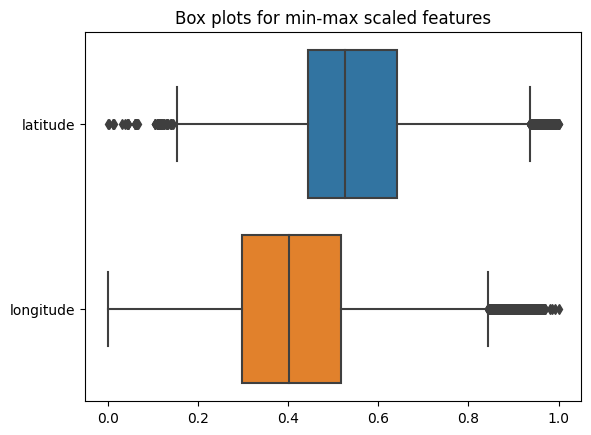

In [ ]:
minmax_scaler = preprocessing.MinMaxScaler()

numerical_features = ['latitude','longitude']

dataScaled = pd.DataFrame(minmax_scaler.fit_transform(cleaned_df[numerical_features]), columns=numerical_features)
#viz_2=sns.violinplot(data=data, y=['price','number_of_reviews'])
ax = sns.boxplot(data=dataScaled, orient="h")
ax.set_title("Box plots for min-max scaled features")

Latitude skewness: 0.43
Longitude skewness: 0.27


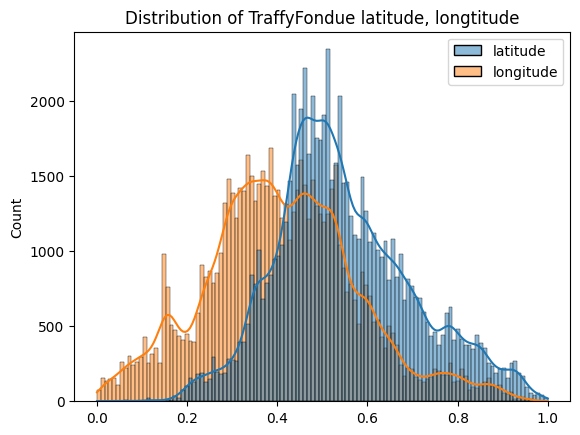

In [ ]:
sns.histplot(dataScaled[['latitude', 'longitude']], kde=True).set_title("Distribution of TraffyFondue latitude, longtitude")
print("Latitude skewness: %.2f"%(dataScaled['latitude'].skew()))
print("Longitude skewness: %.2f"%(dataScaled['longitude'].skew()))

Skewness: 1.57


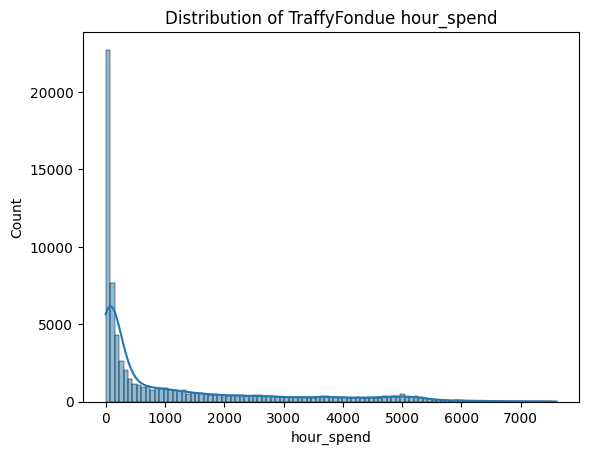

In [48]:
sns.histplot(cleaned_df['hour_spend'], kde=True).set_title("Distribution of TraffyFondue hour_spend")
print("Skewness: %.2f"%(cleaned_df['hour_spend'].skew()))

In [49]:
cleaned_df['hour_spend_log1p'] = cleaned_df['hour_spend'].apply(math.log1p)

Text(0.5, 1.0, 'Box plots for min-max scaled hour_spend')

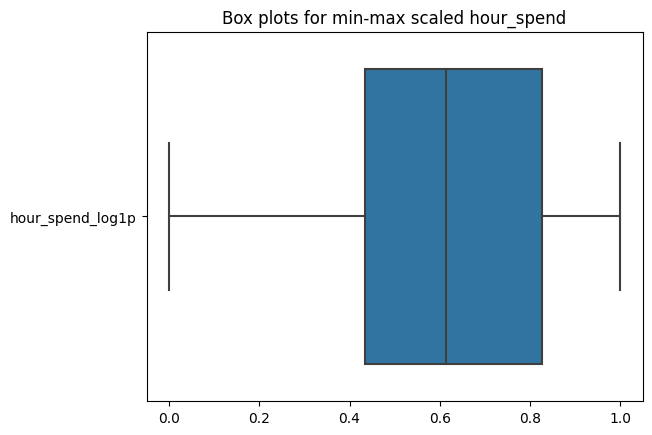

In [50]:
min_max_scaler = preprocessing.MinMaxScaler()

hour_spend_log_scaled = pd.DataFrame(min_max_scaler.fit_transform(cleaned_df[['hour_spend_log1p']]), columns=['hour_spend_log1p'])
ax = sns.boxplot(data=hour_spend_log_scaled, orient="h")
ax.set_title("Box plots for min-max scaled hour_spend")

Skewness: -0.33


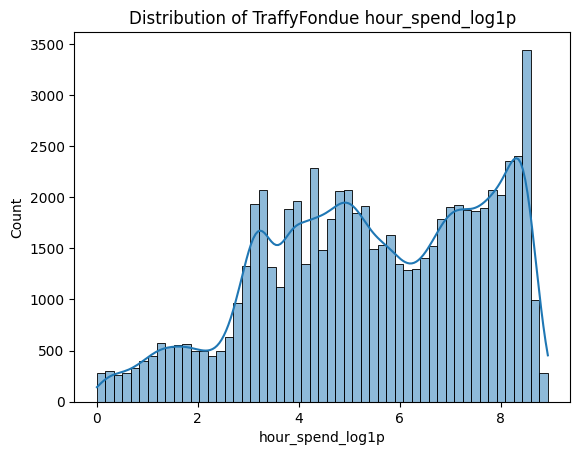

In [51]:
sns.histplot(cleaned_df['hour_spend_log1p'], kde=True).set_title("Distribution of TraffyFondue hour_spend_log1p")
print("Skewness: %.2f"%(cleaned_df['hour_spend_log1p'].skew()))

### Train test split

In [52]:
from sklearn.model_selection import train_test_split

In [55]:
rand_seed = 54
all_features = ['type', 'organization', 'latitude', 'longitude', 'comment', 'hour_spend', 'hour_spend_log1p']

data = cleaned_df[all_features]

In [56]:
data_train, data_test = train_test_split(
    data, test_size=0.2, random_state=rand_seed)

data_train.to_json('data/train.json')
data_test.to_json('data/test.json')

### feature engineering

#### tranforms organization and type

In [2]:
from train.utils import make_binary_feature
import scipy

In [22]:
data_train = pd.read_json('data/train.json')
data_train = data_train.reset_index(drop=True)

In [11]:
data_test = pd.read_json('data/test.json')
data_test = data_test.reset_index(drop=True)

In [12]:
data_test.tail()

,type,organization,latitude,longitude,comment,hour_spend,hour_spend_log1p
14163,[ถนน],[เขตบางคอแหลม],13.68787,100.51702,ตัวเงินตัวทองที่เก็บจากถนนเมื่อวาน,2.6143,1.284898
14164,[แสงสว่าง],[เขตบางเขน],13.88880,100.59821,ไฟฟ้าหลอดดับมานาน อยู่ท้ายซอยมืดมาก,258.4635,5.558616
14165,[ทางเท้า],"[เขตทวีวัฒนา, สำนักการโยธา กทม.]",13.76828,100.34454,ฟุตบาทพังหน้ามหาลัยกรุงเทพธนบุรีครับ,3338.8878,8.113692
14166,[ต้นไม้],[เขตป้อมปราบศัตรูพ่าย],13.75569,100.50631,1 ทางลงไปท่าเรือผ่านฟ้า ทางขึ้นลงแคบมาก แล้วต้...,26.4544,3.312526
14167,[น้ำท่วม],[เขตบางเขน],13.87655,100.59666,วงเวียนบางเขนน้ำท่วมอีกแล้ว,165.2365,5.113411


In [23]:
data_train.head()

,type,organization,latitude,longitude,comment,hour_spend,hour_spend_log1p
0,[จราจร],[เขตสาทร],13.70627,100.52703,ขายของบนทางเท้าทุกวันโดยเฉพาะตอนเย็น ทำให้ฟุตบาทสกปรก และรถติดเพราะคนจอดมาซื้อของ,3.1209,1.416072
1,[ถนน],[เขตห้วยขวาง],13.75177,100.59350,ถนนชำรุด,3654.0707,8.203871
2,[ความสะอาด],[เขตบึงกุ่ม],13.79052,100.65185,แจ้งติดป้าย ผิด พ ร บ รักษาความสะอาด และความเป็นระเบียบเรียบร้อยของบ้านเมือง เค พี เจ มอเตอร์ ถ นวมินทร์ ขอขอบคุณ เจ้าหน้าที่ทุกท่าน ในการจัดการปัญหาดังกล่าว,9.0267,2.305252
3,[กีดขวาง],[เขตพระโขนง],13.68953,100.61746,สุขุมวิท 101 ซอย 28 หมู่บ้านนพรัตน์แจ้งเรื่องกระถางต้นไม้และรางไม้วางอยู่บนถนนเนื่องจากบ้านที่มาสร้างใหม่นำมากีดขวางการสัญจรของคนในหมู่บ้านทำให้เข้าออกลำบากช่วยยกออกให้ด้วยครับขอบคุณครับ,99.7227,4.612371
4,[เสียงรบกวน],[เขตประเวศ],13.68791,100.63943,ไก่ขันเสียงดังเวลา ตี 3-5 ทำให้ไม่สามารถนอนหลับพักผ่อนได้,45.1110,3.831052


In [24]:
type_features = make_binary_feature(data_train['type'], 'type')
org_features = make_binary_feature(data_train['organization'], 'organization')

In [25]:
type_features.shape, org_features.shape

((55393, 24), (55393, 66))

In [27]:
pd.concat((type_features, org_features, data_train[['comment', 'latitude', 'longitude']]), axis=1).tail()

,ถนน,ทางเท้า,แสงสว่าง,ความปลอดภัย,ความสะอาด,น้ำท่วม,กีดขวาง,ท่อระบายน้ำ,จราจร,สะพาน,สายไฟ,เสียงรบกวน,คลอง,ต้นไม้,ร้องเรียน,...,สำนักการระบายน้ำ กทม.,สำนักการวางผังและพัฒนาเมือง กทม.,สำนักการศึกษา กทม.,สำนักงบประมาณกรุงเทพมหานคร,สำนักงานคณะกรรมการข้าราชการกรุงเทพมหานคร,สำนักเทศกิจ กทม.,สำนักป้องกันและบรรเทาสาธารณภัย กทม.,สำนักพัฒนาสังคม กทม.,สำนักยุทธศาสตร์และประเมินผล กทม.,สำนักวัฒนธรรม กีฬาและการท่องเที่ยว กทม.,สำนักสิ่งแวดล้อม กทม.,สำนักอนามัย กทม.,comment,latitude,longitude
55388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,สายสื่อสารย้อยลงมาดูเหมือนจะล่นรบกวนประสานงานให้หน่อยครับ,13.72261,100.45563
55389,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,แจ้งติดป้าย ผิด พ ร บ รักษาความสะอาด และความเป็นระเบียบเรียบร้อยของบ้านเมือง นวมินทร์ 93 ขอขอบคุณ เจ้าหน้าที่ทุกท่าน ในการจัดการปัญหาดังกล่าว,13.79995,100.64970
55390,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ถนนและทางเข้าซอยทรุดโทรม,13.70941,100.40009
55391,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ถนนในซอยวิภาวดีซอย 3 ผิวถนนขรุขระ ครับ,13.79716,100.55843
55392,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ถนน ดินลูกรัชฝุ่น มากมายครับ,13.72171,100.70437


### tranform text

In [30]:
# text processing
from sklearn.feature_extraction.text import CountVectorizer
from pythainlp import word_tokenize

In [31]:
# Same train-test split as before (same random seed)
text_train, text_test = train_test_split(cleaned_df['comment'], test_size=0.2, random_state=rand_seed)

training_corpus = text_train.values.astype('U')
vectorizer = CountVectorizer(min_df=5, tokenizer=word_tokenize, analyzer='word') 
# min_df is the minimum number of times a word needs to appear in the corpus in order to be assigned a vector
vectorizer.fit(training_corpus)
num_words = len(vectorizer.vocabulary_) # Total number of words 
print("Number of distinct words to be used as features:", num_words)

d:\Projects\DS2022-2_TraffyFondue_Project_ML\env\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Number of distinct words to be used as features: 8243


In [32]:
full_corpus = cleaned_df['comment'].values.astype('U')
word_features = vectorizer.transform(full_corpus) # This is a sparse matrix of our word-occurrence features 
words = vectorizer.get_feature_names_out() # The actual words corresponding to the columns of the above feature matrix
word_frequencies = np.array(word_features.sum(axis=0))[0] # The term frequency of each word in the dataset
print("Shape of word-occurrence feature matrix:",word_features.shape)

Shape of word-occurrence feature matrix: (70838, 8243)
